# Walmart Sales Predictions

## Problem Statement:
## Walmart wants to predict and plan their US stores’ weekly sales for their next year based on their markdowns and other external factors.

### Import libraries

In [6]:
import pandas as pd #import pandas
import matplotlib as mpl #import matplotlib
import matplotlib.pyplot as plt #import matplotlib
import numpy as np #import numpy
%matplotlib inline
import seaborn as sns #import Seaborn
mpl.rcParams['figure.figsize'] = (20,5) #set chart size
sns.set_style('darkgrid') #set chart style
import statsmodels.api as sm #import statsmodel
import math #import math
pd.options.display.float_format = '{:.2f}'.format #Setting float format

### Import data

In [7]:
#import csvs
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv').groupby(['Date','Store'])['Weekly_Sales'].sum()

#merge dfs into single df
data_partial = pd.merge(
            features,
            stores,
            on='Store'
        )
data = pd.merge(
            data_partial,
            train,
            on=['Store', 'Date']
        )

#cleaning
data = data.fillna(value=0)

#Getting week number
data['Date'] = pd.to_datetime(data['Date'], errors ='coerce')

data['Week'] = data['Date'].dt.isocalendar().week

#converting True/False to 1/0
data['IsHoliday'] = data['IsHoliday'].astype(int)

#adding a new independent variable to account for a large spike in sales the week before Christmas
data['IsWeek51'] = np.where(data['Week']== 51, 1, 0)

#splitting the data into 80/20% for predictions
data_train = data[(data['Store'] <= 36)].copy() #80% used for regression
data_test = data[(data['Store'] >= 37)].copy() #splitting down to last 20% to test model

## Exploratory Data Analysis

In [8]:
print(data.info())
print('---------------------------------------------------------------------')
print(data.describe())
print('---------------------------------------------------------------------')
print(data.head())
print('---------------------------------------------------------------------')
print(data_train)
print('---------------------------------------------------------------------')
print(data_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Temperature   6435 non-null   float64       
 3   Fuel_Price    6435 non-null   float64       
 4   MarkDown1     6435 non-null   float64       
 5   MarkDown2     6435 non-null   float64       
 6   MarkDown3     6435 non-null   float64       
 7   MarkDown4     6435 non-null   float64       
 8   MarkDown5     6435 non-null   float64       
 9   CPI           6435 non-null   float64       
 10  Unemployment  6435 non-null   float64       
 11  IsHoliday     6435 non-null   int64         
 12  Type          6435 non-null   object        
 13  Size          6435 non-null   int64         
 14  Weekly_Sales  6435 non-null   float64       
 15  Week          6435 non-null   UInt32  

### Data

- Store - The store number
- Date - The date of the beginning of the week being measured
- Temperature - The average high temperature
- Fuel_Price - The average fuel price<br>
- MarkDown1-5 - Anonymous category discounts<br>
- CPI - Consumer Price Index<br>
- Unemployment - Unemployment rate<br>
- IsHoliday - Identifies weeks containing retail holidays<br>
- Type - Anonymous category for the type of store (Supercenter, Neighborhoob Market, etc.)<br>
- Size - Square footage of store<br>
- Weekly_Sales - Weekly sales revenue<br>
- IsWeek51 - Column added to account for Christmas sales spike - Not in original data<br>

### Data Variance

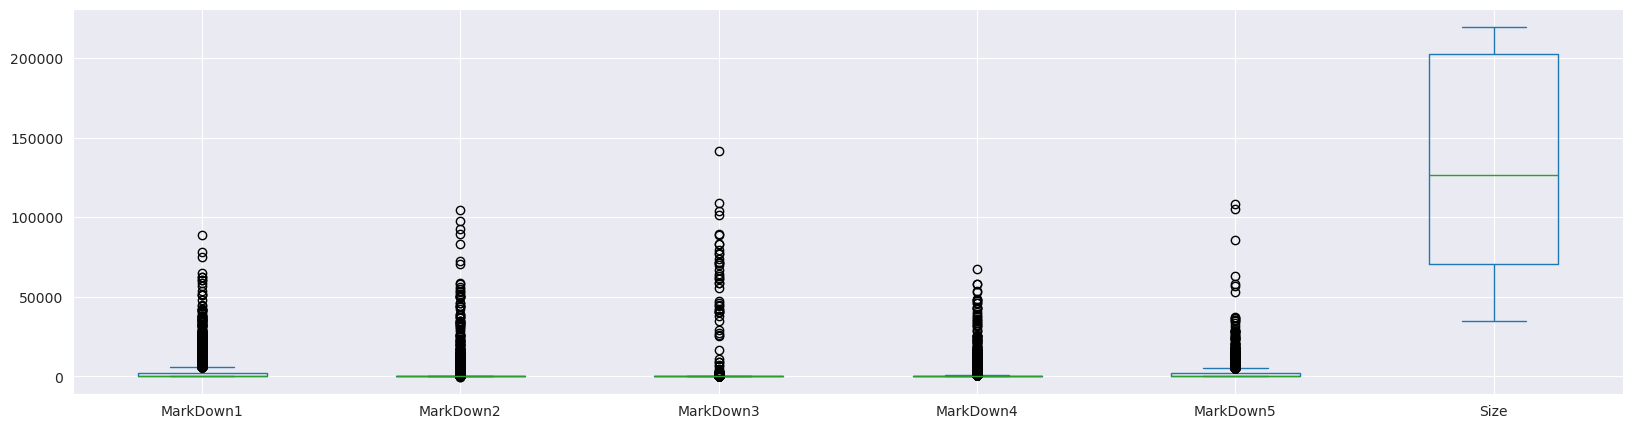

In [9]:
#box chart for non-categorical data grouped for scale
data[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Size']].plot(kind='box')
plt.show()

Markdown1-5 mostly stay at or close to 0. This means that a tremdenous amount of data falls outside of the IQR, but this should not be considered erronious outliers. <br>

Size simply measures the store size. The median store size is 126512. All of the stores fall within 1.5 times the IQR of 70173 and 202307. The variance does not change unless a store increases or decreases in size (builds a new store).

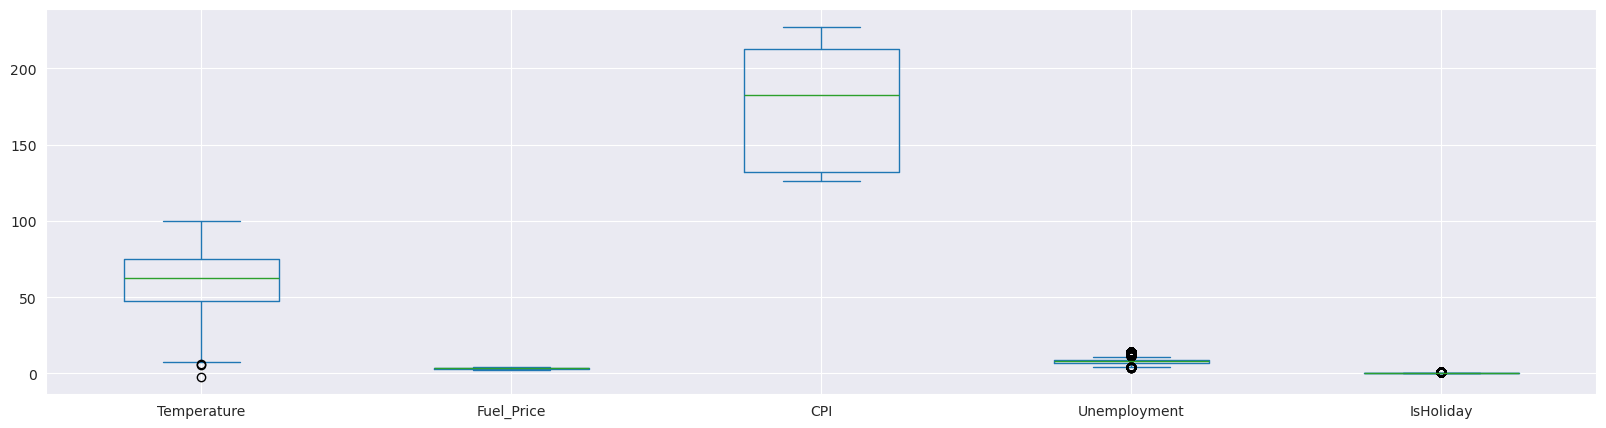

In [10]:
#box chart for non-categorical data grouped for scale
data[['Temperature', 'Fuel_Price','CPI','Unemployment','IsHoliday']].plot(kind='box')
plt.show()

Median temperature was 62. With the exception of two particularly low data points, all of the data fell within 1.5 times the IQR of 47 - 74.</br>

Median fuel price was $3.44. All of the data fell within 1.5 times the IQR of $2.93 and $3.73.</br>

Median CPI was 182.62. All of the data fell within 1.5 times the IQR of 131.74 and 212.74.</br>

Median Unemployment was 7.87. Several data points fell outside 1.5 times the IQR of 6.89 and 8.62. The outlying data points should not be considered erronious.</br>

Median IsHoliday is 0. Only 4 of the 52 weeks measured are holiday weeks, so this is expected and not erronious.

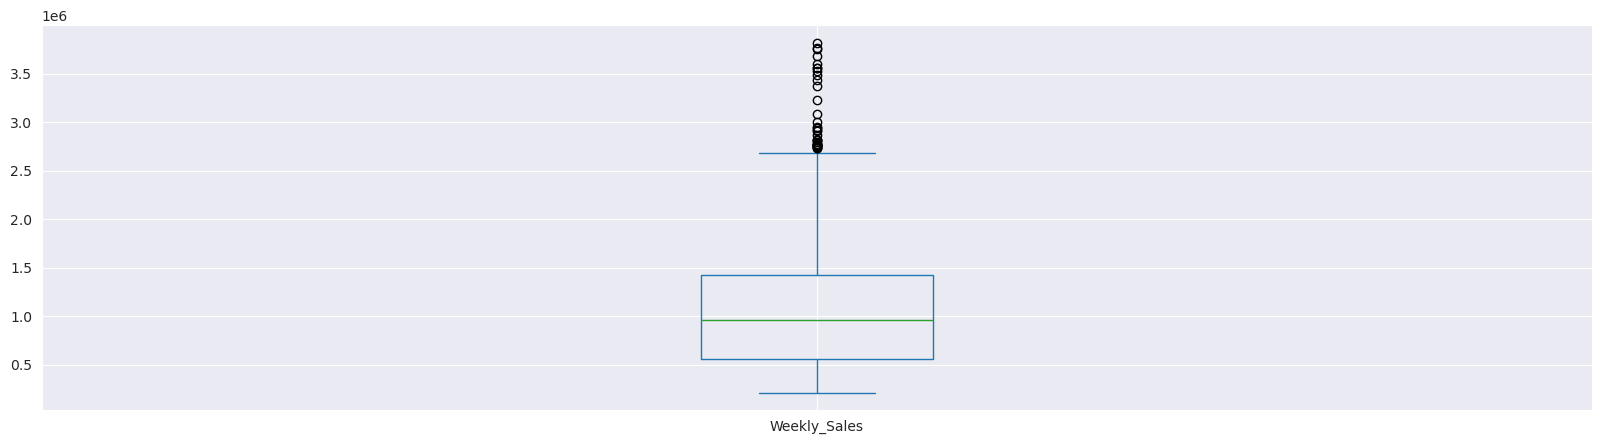

In [11]:
#box chart for Weekly_Sales
data['Weekly_Sales'].plot(kind='box')
plt.show()

## Issue Tree - Internal and External Factors

### Building a model to predict and plan

### Coorelation

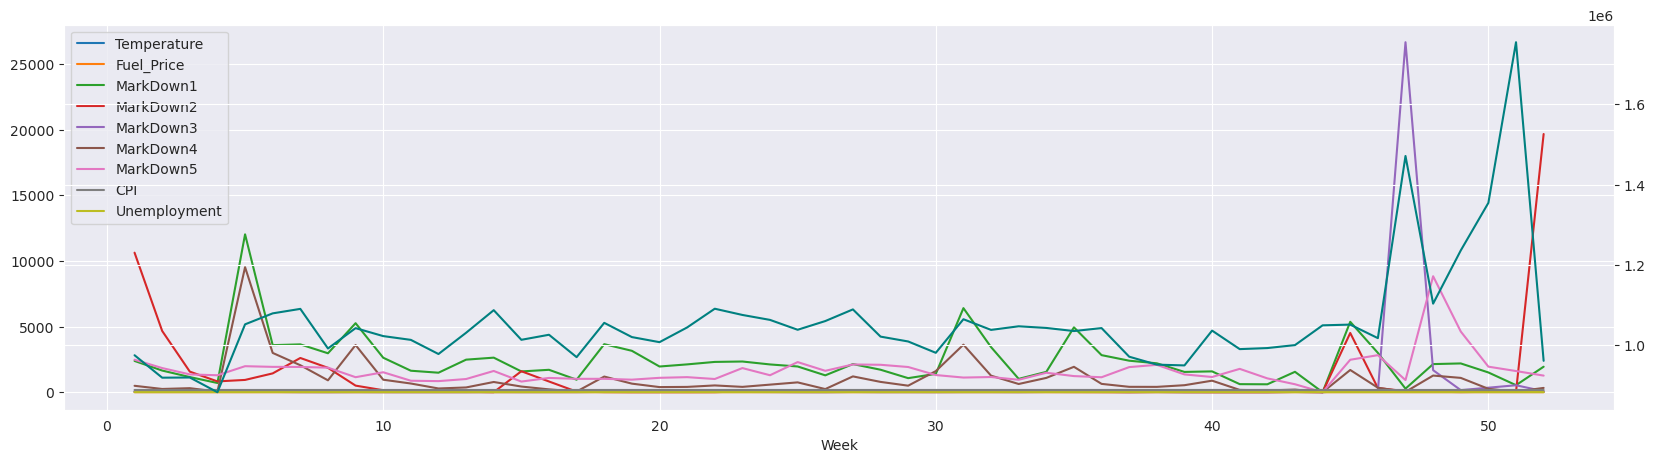

In [12]:
#line chart for numeric data
first_axis = data.groupby(['Week'])[['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment']].mean().plot()
second_axis = first_axis.twinx() #The Twinx function is used to ensure we share the X-Axis for both plots
second_axis.plot(data.groupby(['Week'])['Weekly_Sales'].mean(), color='teal')
plt.show()

From this visualization, we can see a positive correlation between markdowns and weekly sales. Even with two scales, it is hard to distinguish any patterns between each variable and weekly sales. To get a better look, we will compare each variable against weekly sales in a visuals then run get a correlation value.

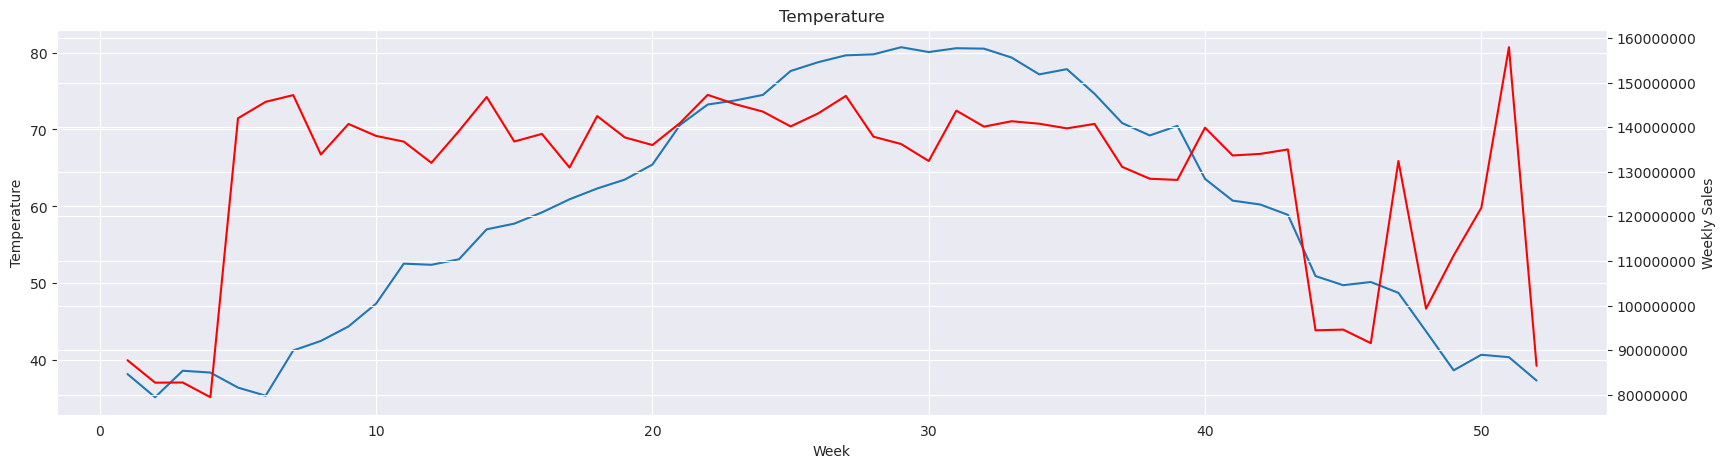

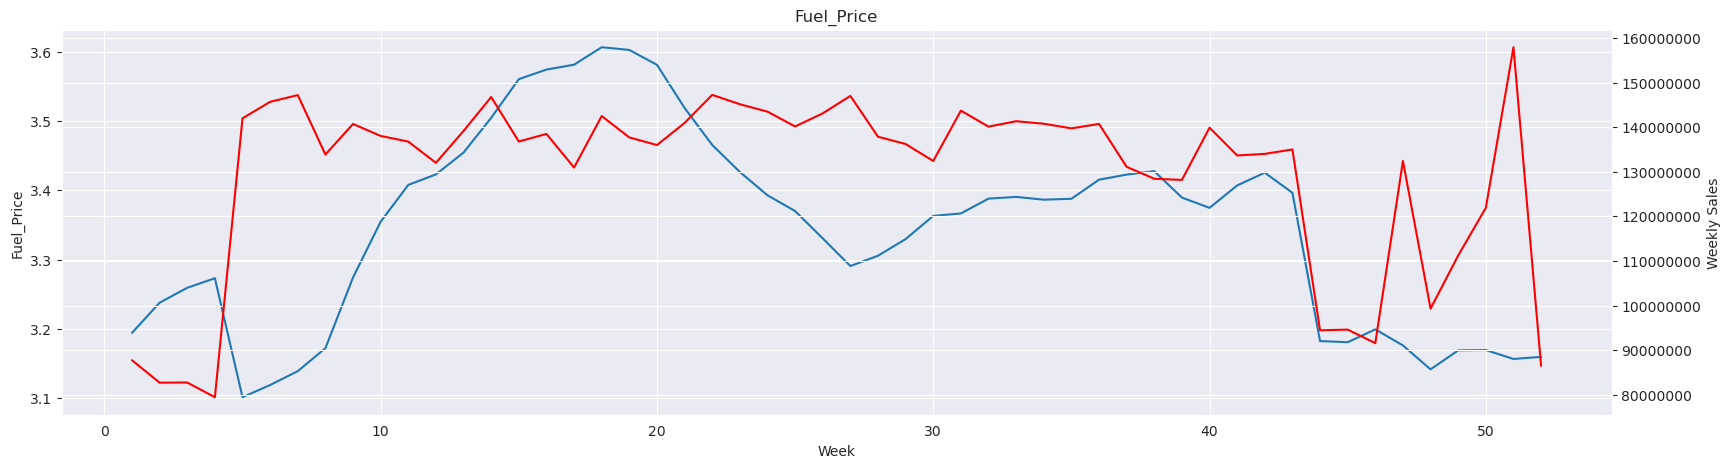

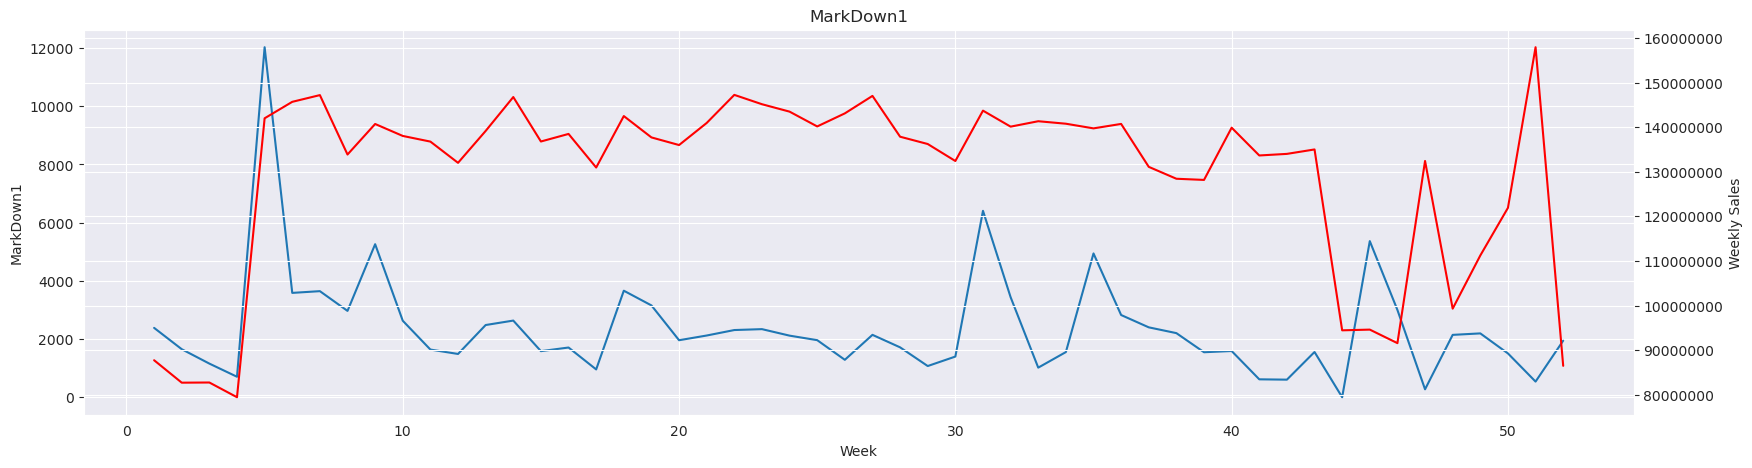

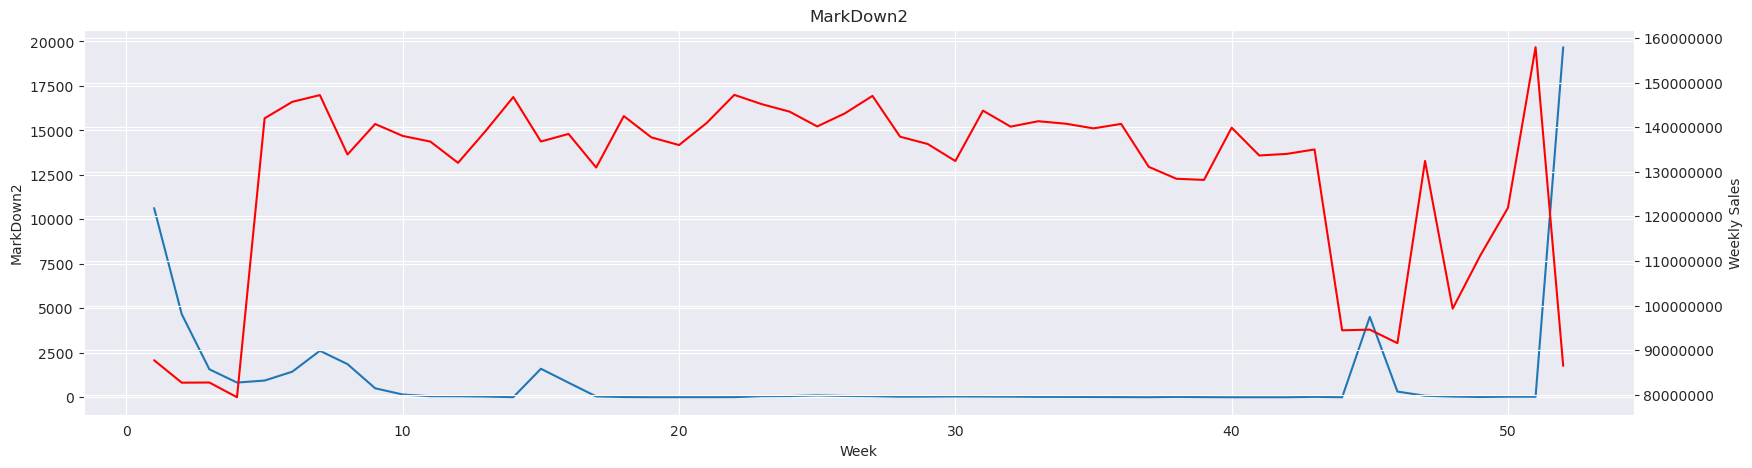

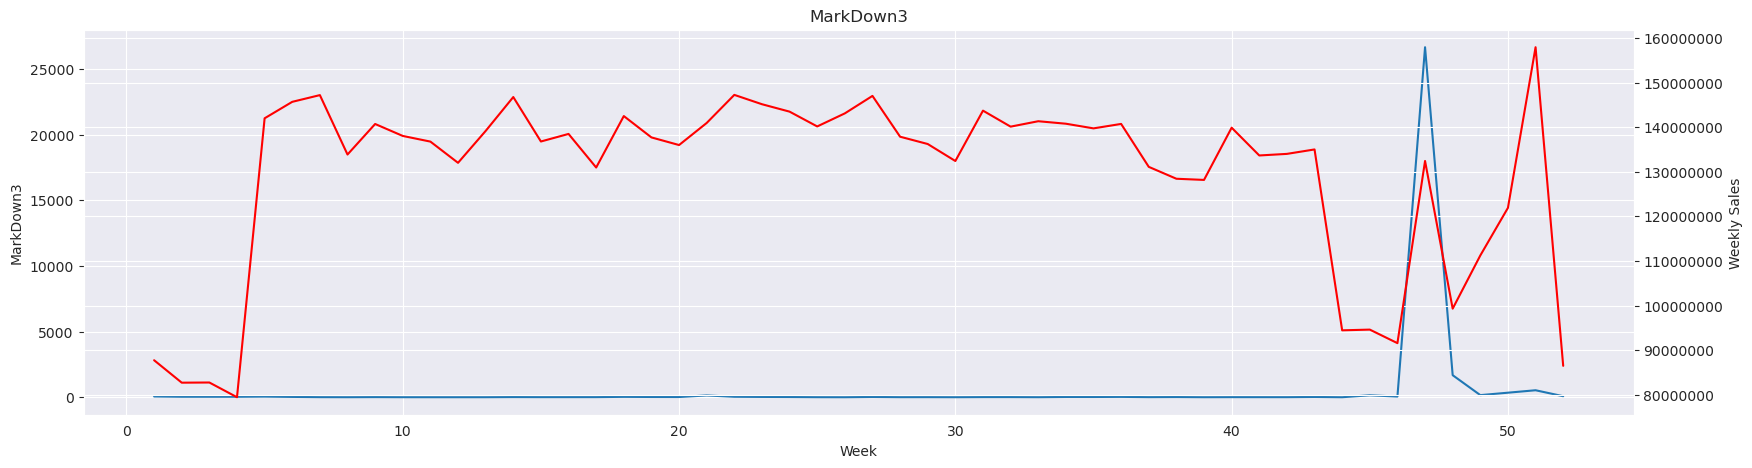

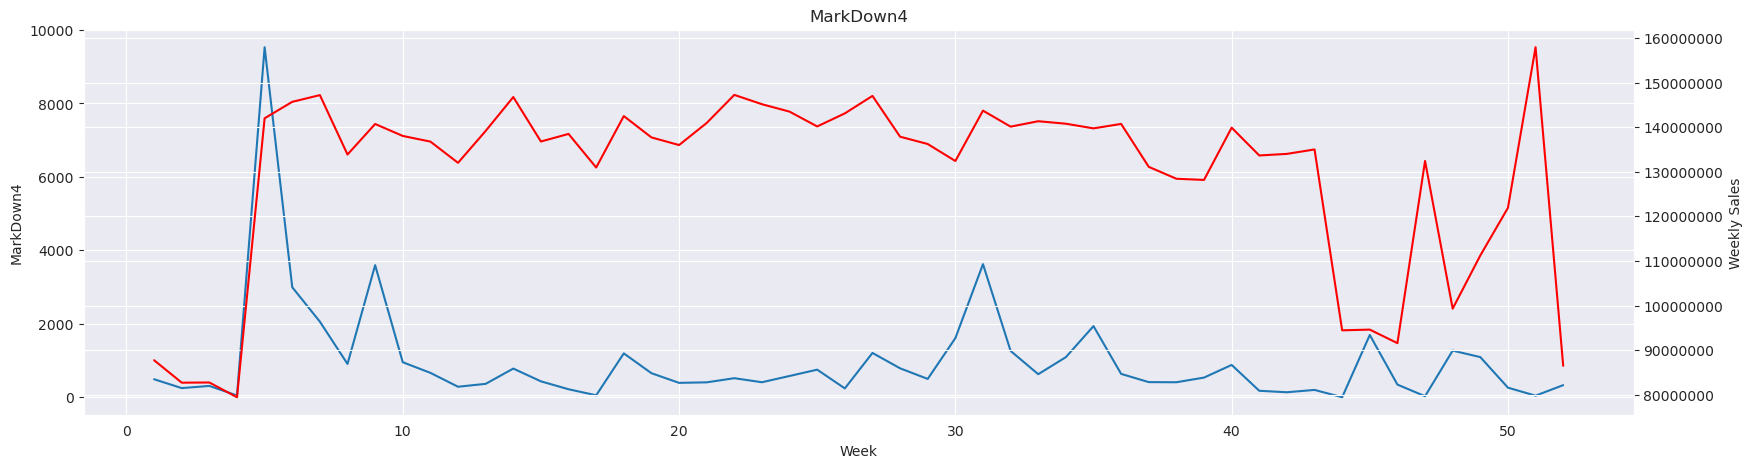

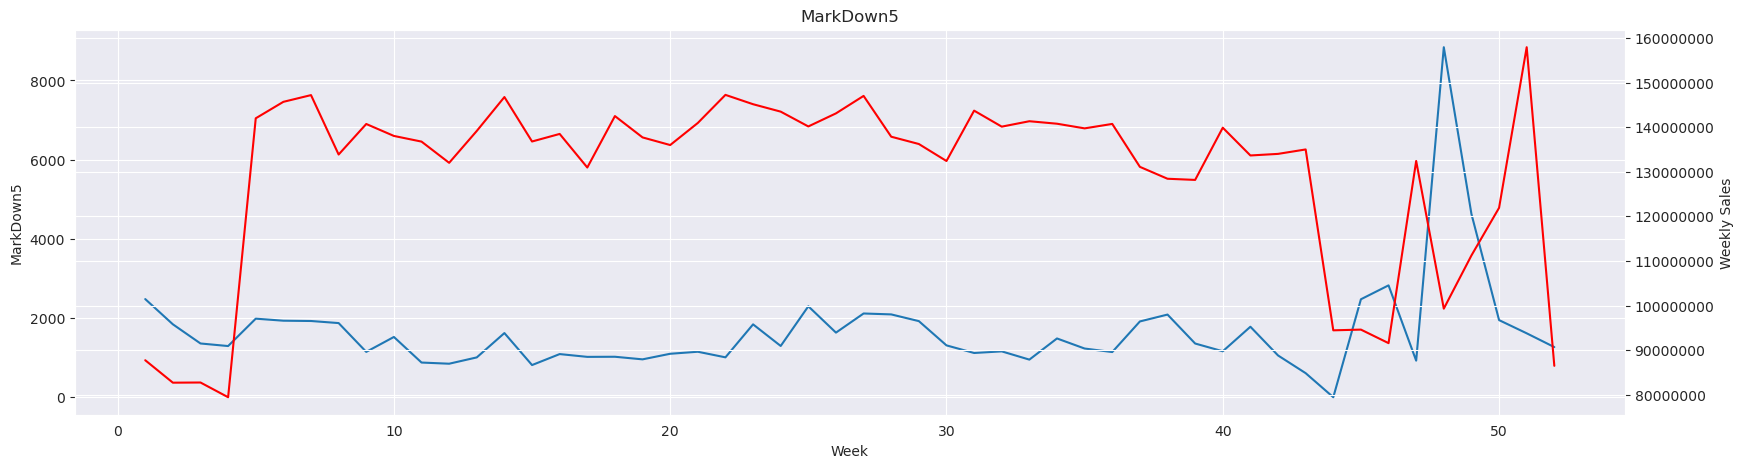

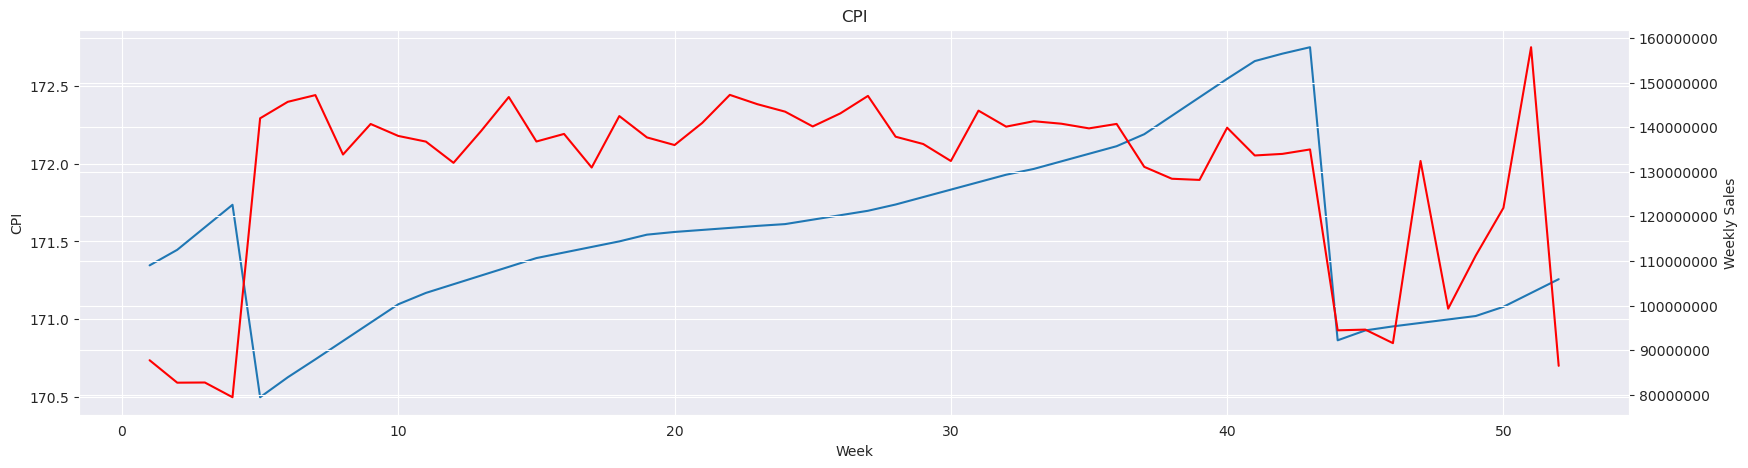

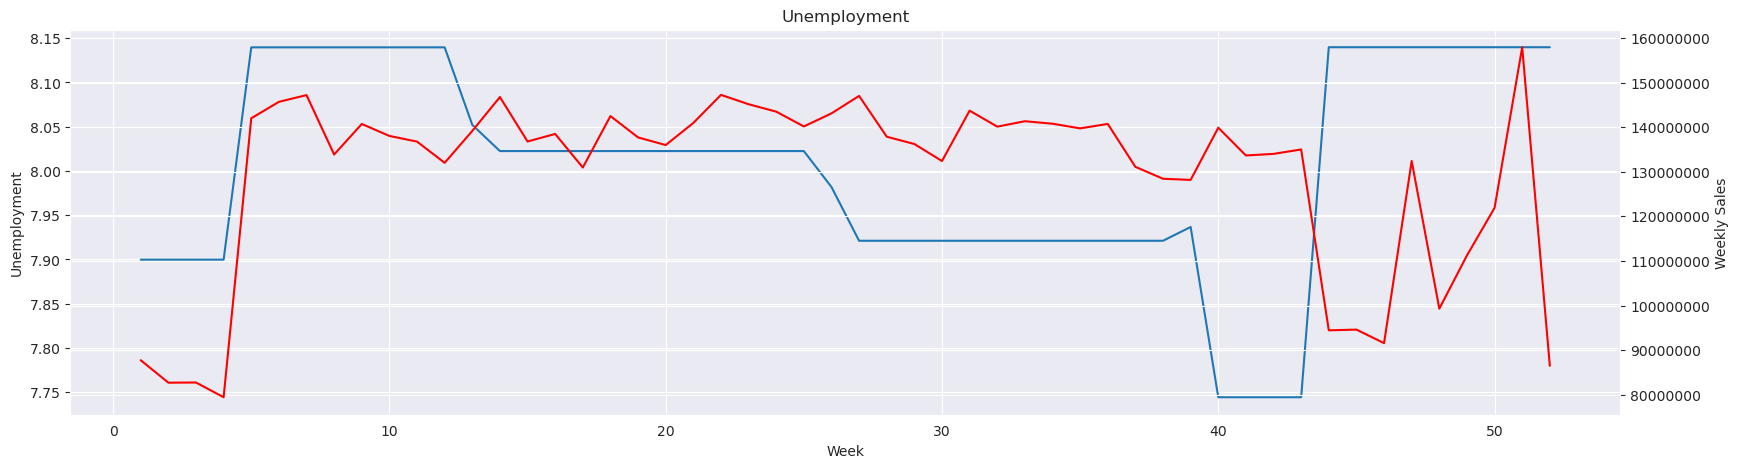

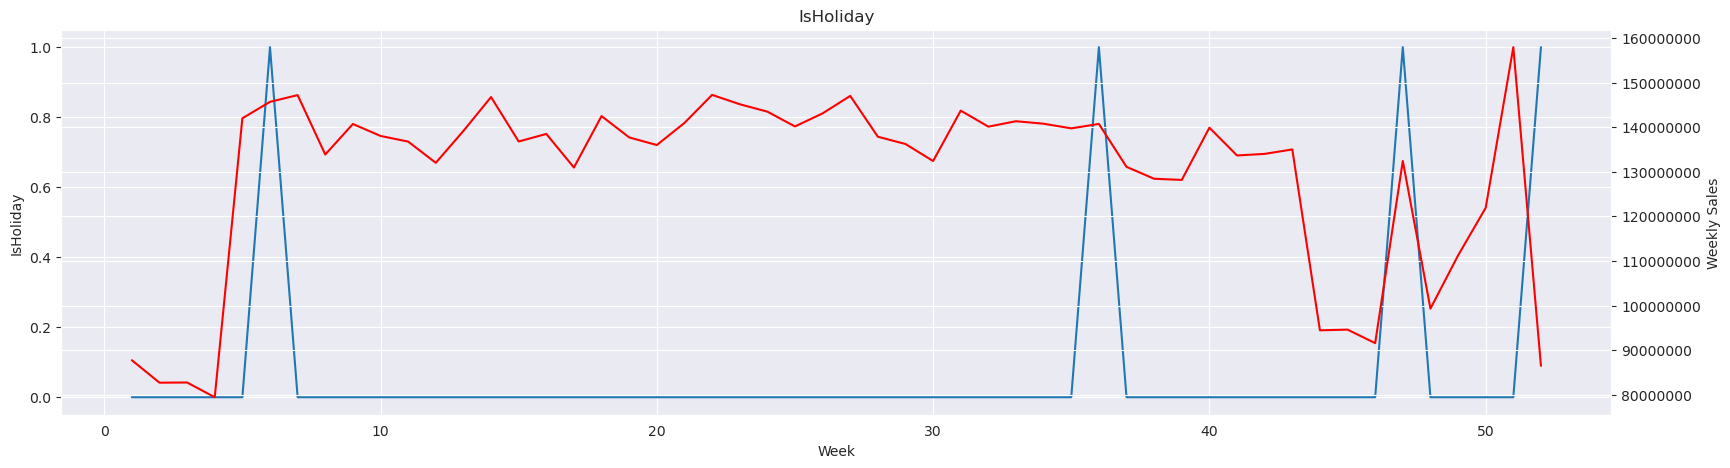

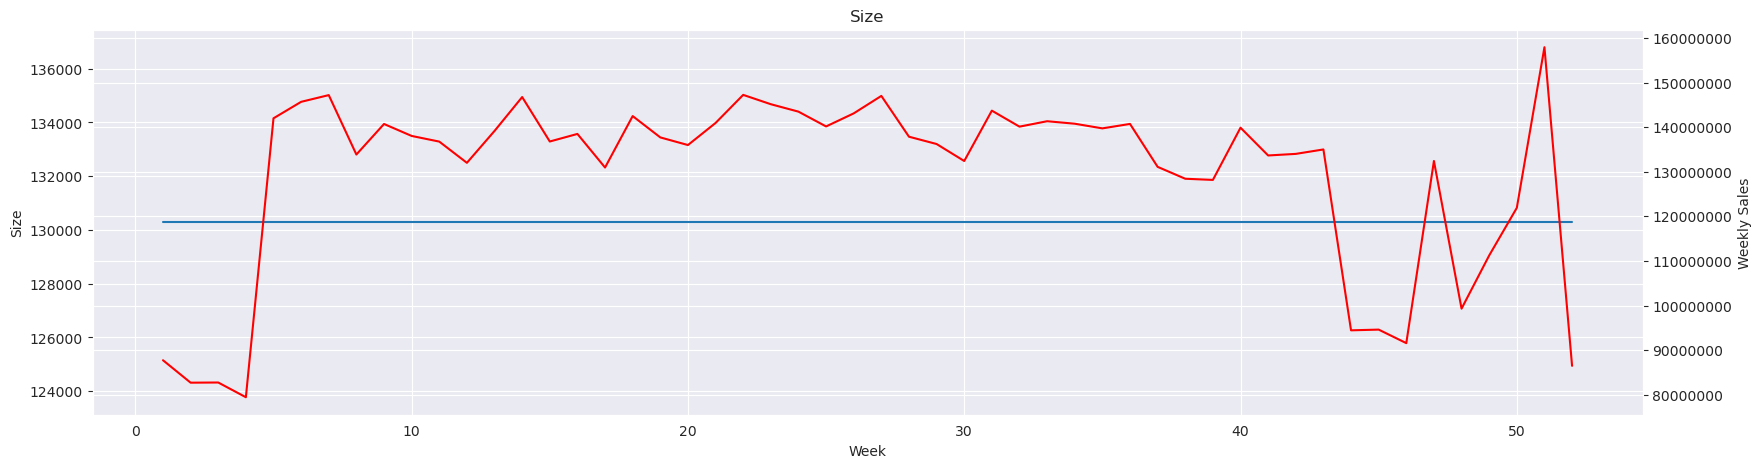

In [13]:
#Create a list of variables to compare against Weekly_Sales
ListOfVariables = ['Temperature',
                   'Fuel_Price',
                   'MarkDown1',
                   'MarkDown2',
                   'MarkDown3',
                   'MarkDown4',
                   'MarkDown5',
                   'CPI',
                   'Unemployment',
                   'IsHoliday',
                   'Size']

#For loop plotting variables against Weekly_Sales
for var in ListOfVariables:
    first_axis = data.groupby(['Week'])[var].mean().plot() #Looping through every variable in data grouping by week and taking the mean.
    second_axis = first_axis.twinx() #Sharing the X-axis for both plots
    second_axis.plot(data.groupby(['Week'])['Weekly_Sales'].sum(), color='red') #Comparing each item in the loop to Weekly_Sales in red
    second_axis.ticklabel_format(useOffset=False, style='plain')
    first_axis.set_ylabel(var)
    second_axis.set_ylabel('Weekly Sales')
    plt.title(var)
    plt.show()

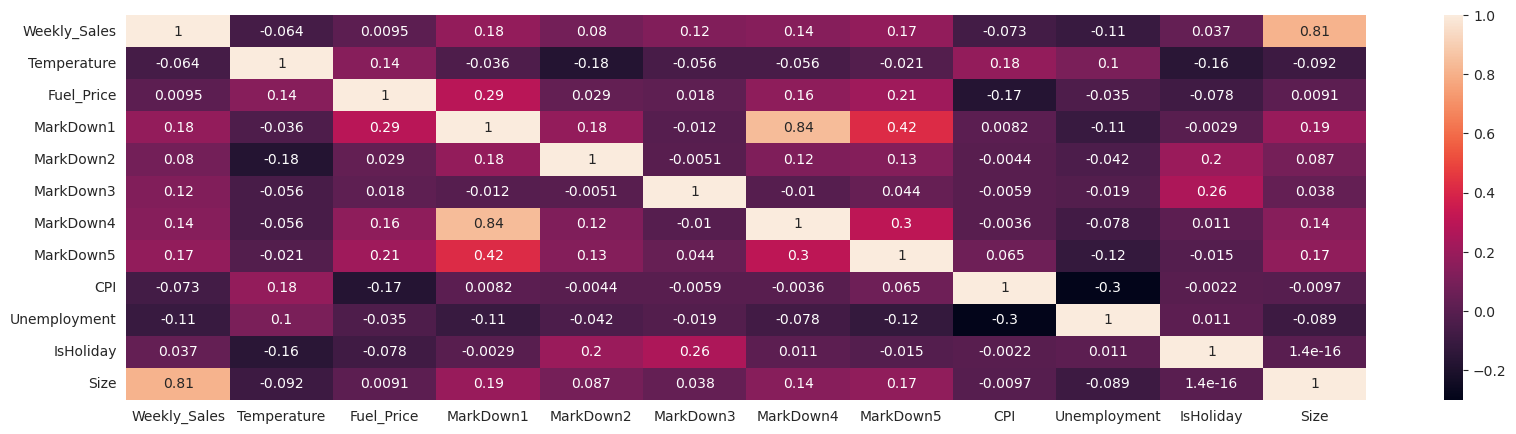

In [14]:
data_corr = data[['Weekly_Sales',
                 'Temperature',
                 'Fuel_Price',
                 'MarkDown1',
                 'MarkDown2',
                 'MarkDown3',
                 'MarkDown4',
                 'MarkDown5',
                 'CPI',
                 'Unemployment',
                 'IsHoliday',
                 'Size']].corr() #Get correlations

sns.heatmap(data_corr, annot=True) #create heatmap for correlations

data_corr.to_csv('corr.csv')

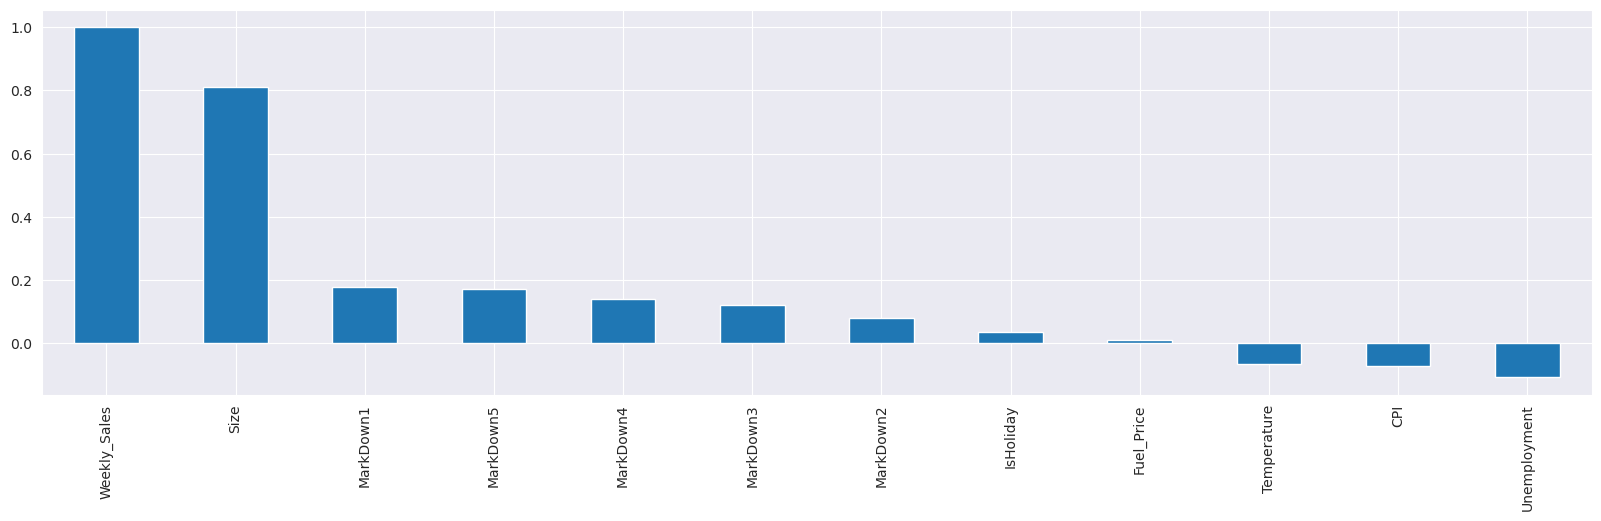

In [15]:
#visualize correlations descending
data_corr['Weekly_Sales'].sort_values(ascending=False).plot(kind='bar')
plt.show()

As expected, store size has the largest effect on weekly sales. It is a positive correlation of .81. The store size represents the population of the area, the expected usage of the store, and other facotrs of the store's location. Also, the greater the size, the greater the possible inventory.</br>

Markdowns 1-5 all have the next largest positive effect on weekly sales. The correlations range from .08 to .18.</br>

IsHoliday has a .037 correlation coefficent with weekly sales. This makes sense as while consumers are generally more engaged during retail holidays, the discounts should be what drives consumers to particular stores.</br>

Somewhat unexpectedly, fuel price has a positive correlation of .00095. The correlation is extremely small. This could be indicative of consumers traveling less and spending more at the store.</br>

Temperature has a -0.064 correlation with weekly sales. Though low, it represents the idea that shoppers spend less during the warm months of the year. This could be influenced by the retail holidays all occurring in the cooler months.</br>

CPI has an expected -0.073 correlation. CPI or consumer price index measures inflation from period to period. As inflation increases, consumers' purchasing power decreases.</br>

Unemployment also has an expected negative correlation of -0.11. The lower employment rate, the less money there is to spend in the area.

### Regression

To build our model, we will run a regressor to obtain the R-squared (fit) and regression coefficients.

In [16]:
#list independent variables to be used in the regression, using only the first 80% of stores listed
independent_variables = data_train[['Temperature',
                   'Fuel_Price',
                   'MarkDown1',
                   'MarkDown2',
                   'MarkDown3',
                   'MarkDown4',
                   'MarkDown5',
                   'CPI',
                   'Unemployment',
                   'IsHoliday',
                   'Size']]
independent_variables = sm.add_constant(independent_variables) #add constant to independent variables

dependent_variables = data_train['Weekly_Sales'] #set dependent variable

regression_model = sm.OLS(dependent_variables, independent_variables).fit() #run regression

regression_model.summary() #display results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     922.8
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:01:22   Log-Likelihood:                -72805.
No. Observations:                5148   AIC:                         1.456e+05
Df Residuals:                    5136   BIC:                         1.457e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.849e+05   5.86e+04     16.809      0.000     8.7e+05     1.1e+06
Temperature   1062.6979    271.821      3.910      0.000     529.813    1595.583
Fuel_Price   -6.671e+04   1.14e+04     -5.841      0.000   -8.91e+04   -4.43e+04
MarkDown1        0.4822      1.545      0.312      0.755      -2.547       3.512
MarkDown2        0.0975      0.954      0.102      0.919      -1.772       1.967
MarkDown3        8.7014      0.868     10.027      0.000       7.000      10.403
MarkDown4        1.4666      2.200      0.667      0.505      -2.846       5.779
MarkDown5        6.0170      1.622      3.710      0.000       2.838       9.196
CPI          -2348.5924    135.097    -17.385      0.000   -2613.440   -2083.745
Unemployment -4.748e+04   2965.262    -16.012      0.000   -5.33e+04   -4.17e+04
IsHoliday      4.81e+04   1.98e+04      2.432      0.015    9328.507    8.69e+04
Size             7.5677      0.081     93.916      0.000       7.410       7.726
==============================================================================
Omnibus:                     1329.070   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4720.133
Skew:                           1.265   Prob(JB):                         0.00
Kurtosis:                       6.950   Cond. No.                     1.91e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared of this regression is 0.664.

### Coefficients

In [17]:
#display coeff values
coeff = regression_model.params.sort_values(ascending=False)
print(coeff)

const          984886.64
IsHoliday       48100.98
Temperature      1062.70
MarkDown3           8.70
Size                7.57
MarkDown5           6.02
MarkDown4           1.47
MarkDown1           0.48
MarkDown2           0.10
CPI             -2348.59
Unemployment   -47480.05
Fuel_Price     -66709.01
dtype: float64


In [18]:
#export coeff values for use in data visualization
coeff.to_csv('coeff.csv')

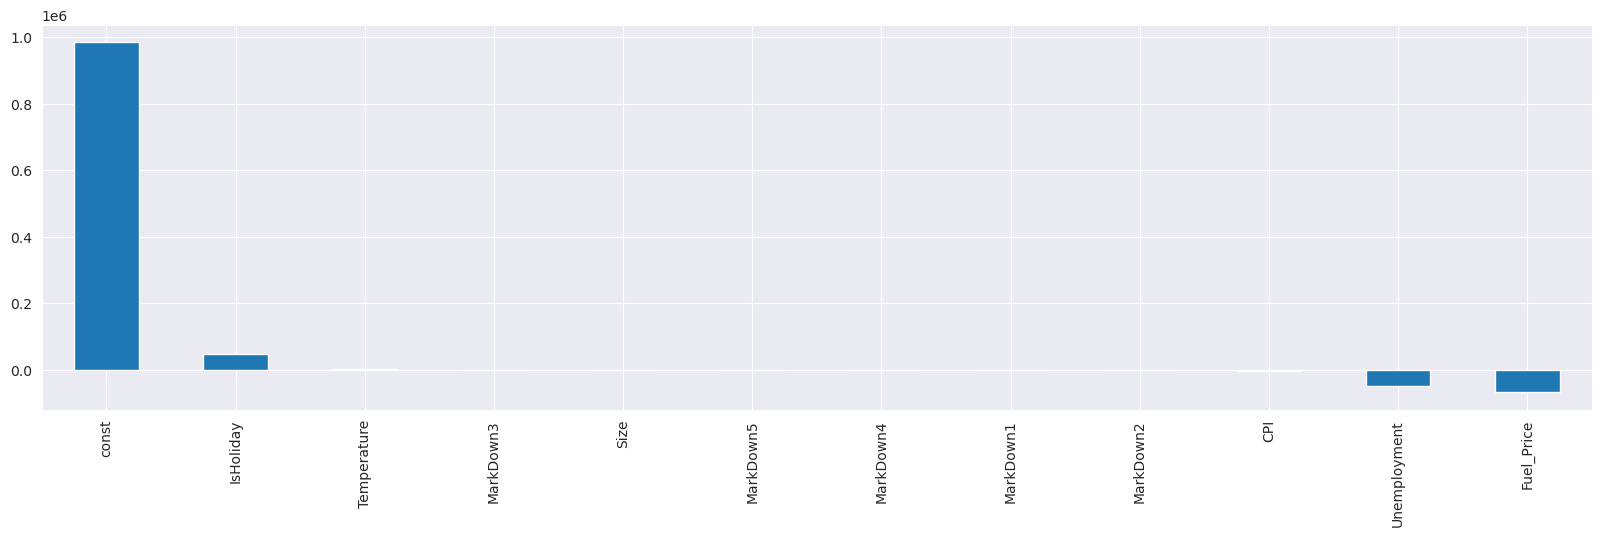

In [19]:
#create a bar chart the visualizes the coefficients
regression_model.params.sort_values(ascending=False).plot(kind='bar')
plt.show()

### Prediction

In [20]:
#setting independent variables for prediction
independent_variables_test = data_test[['Temperature',
                   'Fuel_Price',
                   'MarkDown1',
                   'MarkDown2',
                   'MarkDown3',
                   'MarkDown4',
                   'MarkDown5',
                   'CPI',
                   'Unemployment',
                   'IsHoliday',
                   'Size']]
independent_variables_test = sm.add_constant(independent_variables_test) #add constant
data_test['Prediction'] = regression_model.predict(independent_variables_test) #adding predictions to data
print(data_test['Prediction']) #confirming values were assigned

5148   265187.10
5149   314699.55
5150   268275.54
5151   270601.51
5152   266745.62
          ...   
6430   842927.92
6431   839814.18
6432   833291.75
6433   822461.79
6434   828248.37
Name: Prediction, Length: 1287, dtype: float64


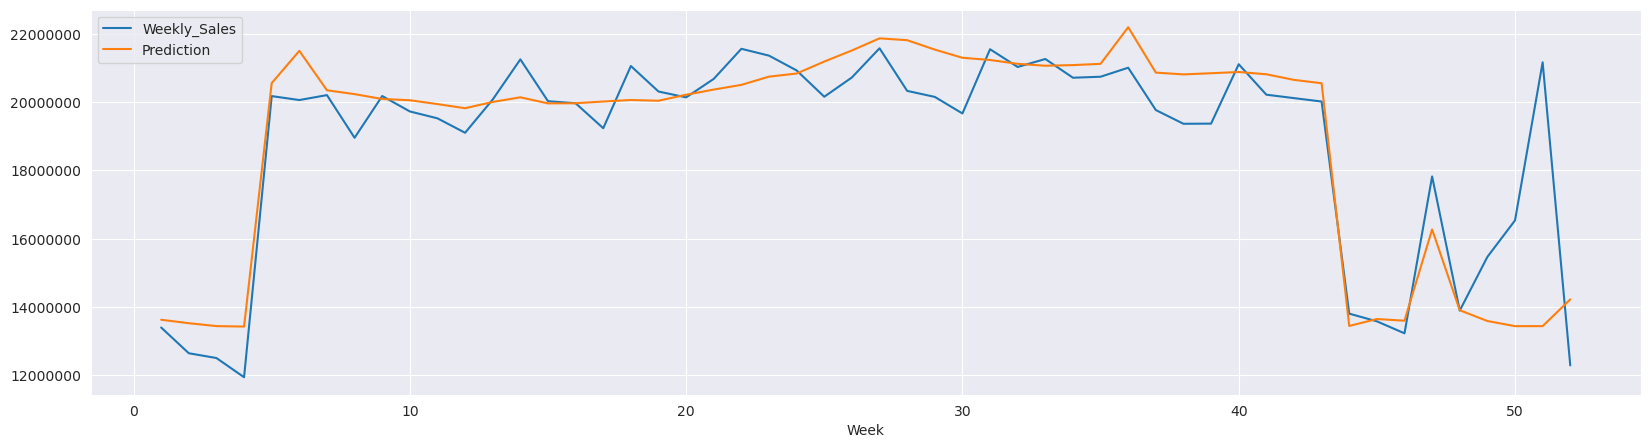

In [21]:
x = data_test.groupby(['Week'])[['Weekly_Sales','Prediction']].sum().plot(kind='line')
x.ticklabel_format(useOffset=False, style='plain')
plt.show()

### RMSE

Root Mean Squared Error (RMSE) measures the average error performed by the model. MSE = mean((observeds - predicteds)^2) and RMSE = sqrt(MSE). The lower the RMSE, the better the model.

In [22]:
#define function for RMSE
def RMSE(observations, predictions):
    MSE = ((observations - predictions)**2).mean()
    RMSE = math.sqrt(MSE)
    print(RMSE)

In [23]:
RMSE(data_test['Weekly_Sales'], data_test['Prediction'])

294025.24936819123


The model has an RMSE of 294025. It is obvious from the visualization that none of the variables are accounting for the last spike. Through domain knowledge of retail sales, we know this spike is for Christmas. This data includes last minute shopping, exchanges, and gift cards/cash gifted.</br>

I have added the variable "IsWeek51" to the data set and will rerun the regression and prediction with it included.

### Regression with IsWeek51

In [24]:
#adding 'IsWeek51' to previous independent_variables
independent_variables = data_train[['Temperature',
                   'Fuel_Price',
                   'MarkDown1',
                   'MarkDown2',
                   'MarkDown3',
                   'MarkDown4',
                   'MarkDown5',
                   'CPI',
                   'Unemployment',
                   'IsHoliday',
                   'Size',
                   'IsWeek51']]
independent_variables = sm.add_constant(independent_variables) #add constant to independent variables

dependent_variables = data_train['Weekly_Sales'] #set dependent variable

regression_model = sm.OLS(dependent_variables, independent_variables).fit() #run regression

regression_model.summary() #display results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     960.4
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:01:22   Log-Likelihood:                -72583.
No. Observations:                5148   AIC:                         1.452e+05
Df Residuals:                    5135   BIC:                         1.453e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.303e+05   5.62e+04     16.558      0.000     8.2e+05    1.04e+06
Temperature   1845.7597    262.910      7.020      0.000    1330.344    2361.176
Fuel_Price   -6.137e+04   1.09e+04     -5.608      0.000   -8.28e+04   -3.99e+04
MarkDown1        1.0661      1.480      0.720      0.471      -1.836       3.968
MarkDown2        0.6937      0.914      0.759      0.448      -1.098       2.485
MarkDown3        8.5928      0.831     10.337      0.000       6.963      10.222
MarkDown4        1.6955      2.107      0.805      0.421      -2.436       5.827
MarkDown5        5.0623      1.554      3.258      0.001       2.016       8.109
CPI          -2423.1923    129.455    -18.718      0.000   -2676.979   -2169.405
Unemployment  -4.89e+04   2841.175    -17.210      0.000   -5.45e+04   -4.33e+04
IsHoliday     6.818e+04    1.9e+04      3.595      0.000     3.1e+04    1.05e+05
Size             7.5653      0.077     98.013      0.000       7.414       7.717
IsWeek51      8.318e+05   3.87e+04     21.504      0.000    7.56e+05    9.08e+05
==============================================================================
Omnibus:                      656.947   Durbin-Watson:                   0.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1086.502
Skew:                           0.873   Prob(JB):                    1.17e-236
Kurtosis:                       4.419   Cond. No.                     1.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared has increased to 0.692 from the previous regression using the new variable.

In [25]:
regression_model.params.sort_values(ascending=False)

const          930300.55
IsWeek51       831781.04
IsHoliday       68180.57
Temperature      1845.76
MarkDown3           8.59
Size                7.57
MarkDown5           5.06
MarkDown4           1.70
MarkDown1           1.07
MarkDown2           0.69
CPI             -2423.19
Unemployment   -48895.20
Fuel_Price     -61367.16
dtype: float64

In [26]:
#adding 'IsWeek51' to prior set of independent variables
independent_variables_test = data_test[['Temperature',
                   'Fuel_Price',
                   'MarkDown1',
                   'MarkDown2',
                   'MarkDown3',
                   'MarkDown4',
                   'MarkDown5',
                   'CPI',
                   'Unemployment',
                   'IsHoliday',
                   'Size',
                   'IsWeek51']]
independent_variables_test = sm.add_constant(independent_variables_test) #add constant
data_test['Prediction_new'] = regression_model.predict(independent_variables_test) #adding predictions to data
print(data_test['Prediction_new']) #confirming values were assigned

5148   232480.72
5149   302043.44
5150   235002.25
5151   241656.65
5152   238500.45
          ...   
6430   833498.59
6431   831667.58
6432   813296.29
6433   806199.95
6434   815184.45
Name: Prediction_new, Length: 1287, dtype: float64


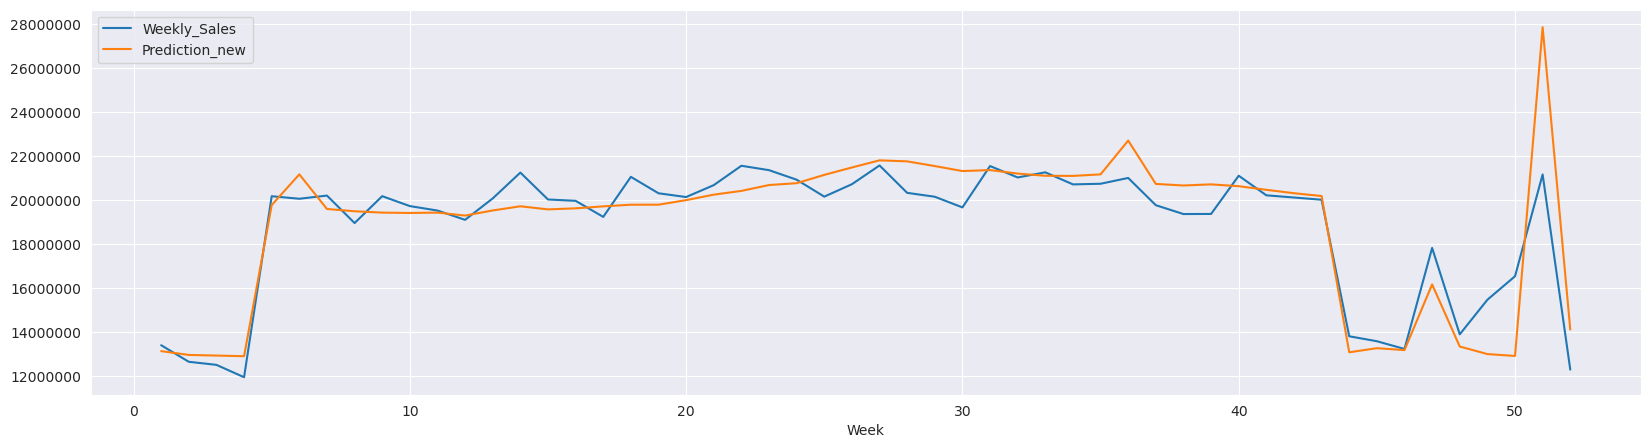

In [27]:
x = data_test.groupby(['Week'])[['Weekly_Sales','Prediction_new']].sum().plot(kind='line')
x.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [28]:
RMSE(data_test['Weekly_Sales'], data_test['Prediction_new'])

289812.4301872484


The model has an RMSE of 289812. That is down from 294025 on the previous model.</br>

The model appears to be a good fit overall. It over predicts the Christmas sales and slightly underpredicts Black Friday / Cyber Monday for the last 20% of stores, but otherwise is a good fit visually.


### Export CSVs

In [29]:
#exporting csvs for use in Tableau
data.to_csv('data_finalized.csv')
data_train.to_csv('data_train_finalized.csv')
data_test.to_csv('data_test_finalized.csv')